# Regime definition for the Antarctic Slope Current

This script:

1. Defines different regimes of the Antarctic Slope Current along the 1000-m isobath:
    - Reverse ASC has a positive sign in the barotropic velocity.
    - Surface-intensified ASC has larger velocities in the upper water column.
    - Bottom-intensified ASC has larger velocity in the lower water column. (We ended up using a % rule: bottom velocity has to be at least 50%.)
2. Save a vector with the ASC classificaion to a *.npz file.

Parameters that can be changed:
- classification is here done for along-slope velocity along the 1 km isobath, 10 yr mean and monthly climatology
- definition (of 'surface' and 'bottom' flow)
- along-slope averaging

Load modules:

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
# Optional modules
import xarray.ufuncs as xu
import xgcm
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.colors as colors
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [2]:
client = Client() # n_workers=8
client

Client Scheduler: tcp://127.0.0.1:40111 Dashboard: /proxy/34261/status,Cluster Workers: 4 Cores: 8 Memory: 32.00 GiB


Nominate a database from which to load the data and define an experiment:

In [3]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Load data

Velocity along 1000-m contour

Data has been previously calculated using `Calc_u_on_depth_contour.ipynb` and `Find_depth_contour_plt_approach.ipynb`. 

In [5]:
data_path = '/g/data/x77/wgh581/Post_Process/'
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'

data = np.load(data_path + file_name)
data.files

['u_along_contour',
 'v_cross_contour',
 'u_btr_contour',
 'v_btr_contour',
 'lat_along_contour',
 'lon_along_contour',
 'num_points',
 'distance_along_contour',
 'st_ocean',
 'thickness_contour']

In [6]:
u_along_contour   = data['u_along_contour']
u_btr_contour     = data['u_btr_contour']
# All on u-grid (velocity)
num_points        = data['num_points']
distance_along_contour = data['distance_along_contour']
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']
st_ocean          = data['st_ocean']
thickness_contour = data['thickness_contour']

In [7]:
# If using *_plt_approach, overwrite last value
distance_along_contour[-1] = distance_along_contour[-2]+1 

### Prepare plotting

In [4]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Load bathymetry

In [8]:
lat_slice = slice(-80, -59)

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)

# Select latitude range
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

Land mask

In [9]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

Paths, colormaps, ...

In [10]:
ft_size = 18
fig_path = '/g/data/x77/wgh581/Figures/'

In [11]:
# Costum colormap
import matplotlib
colorsList_no4 = [('lightgreen'),('blueviolet'),('tomato'),('c')]
CustomCmap_no4 = matplotlib.colors.ListedColormap(colorsList_no4)
colorsList_no3 = [('lightgreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

### Smoothing along the contour

In [12]:
# Function that smooths the data
def running_mean_2d(in_data, N):
    out_data = np.empty((np.shape(in_data)[0],np.shape(in_data)[1]))
    for yy in range(np.shape(in_data)[0]):
        cumsum_tmp = np.nancumsum(np.insert(in_data[yy,:], 0, np.nan))
        out_data[yy,int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

def running_mean_1d(in_data, N):
    out_data = np.empty((np.shape(in_data)[0]))
    cumsum_tmp = np.nancumsum(np.insert(in_data, 0, np.nan))
    out_data[int(N/2):-int(N/2)+1] = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    return out_data

Smooth along-slope velocity

In [13]:
# Smooth by 20 in along-slope direction (20 points on isobath, not actually model grid cells)
N = 20

u_along_clim = np.zeros((np.size(u_along_contour,0), np.size(u_along_contour,1), np.size(u_along_contour,2)))
for tt in range(len(month)):
    u_along_clim[tt,:,:] = running_mean_2d(u_along_contour[tt,:,:], N)

u_btr_clim = np.zeros((np.size(u_btr_contour,0), np.size(u_btr_contour,1)))
for tt in range(len(month)):
    u_btr_clim[tt,:] = running_mean_1d(u_btr_contour[tt,:], N)

Fill the values at the beginning and end with their high resolution / unsmoothed values, respectively.

In [14]:
u_along_clim[:, :, :int(N/2)]  = u_along_contour[:,:,:int(N/2)]
u_along_clim[:, :, -int(N/2):] = u_along_contour[:,:,-int(N/2):]

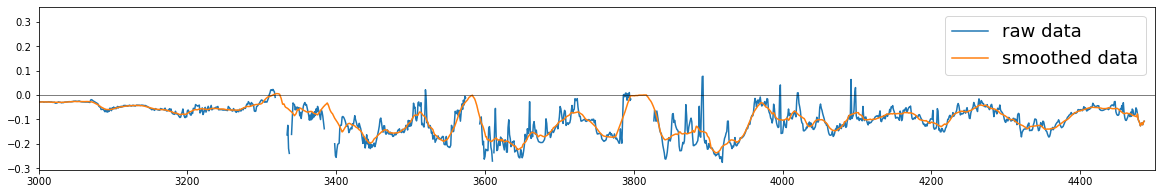

In [16]:
# Plot raw and smoothed data
test   = u_along_contour.mean(axis=0)[10,:]
test_2 = u_along_clim.mean(axis=0)[10,:]
fig = plt.figure(figsize=(20,3))
plt.plot(test, label='raw data')
plt.plot(test_2, label='smoothed data')
plt.legend(fontsize=ft_size)
plt.xlim(3000, 4500)
plt.axhline(color='k', linewidth=0.5);

### Side note: Be aware of flaws in the selection of 1 km isobath:  
- The maximum depth is quite often much deeper than 1000 m. The 2 figures below show this.
- Using the *plt_approach* for contour selection gives better results than using the *mask_approach*.

In [15]:
# Load max_depth for *_plt_approach dataset:
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_1000m_plt_approach.npz'
data = np.load(file_path)
max_depth = data['h_contour_u']

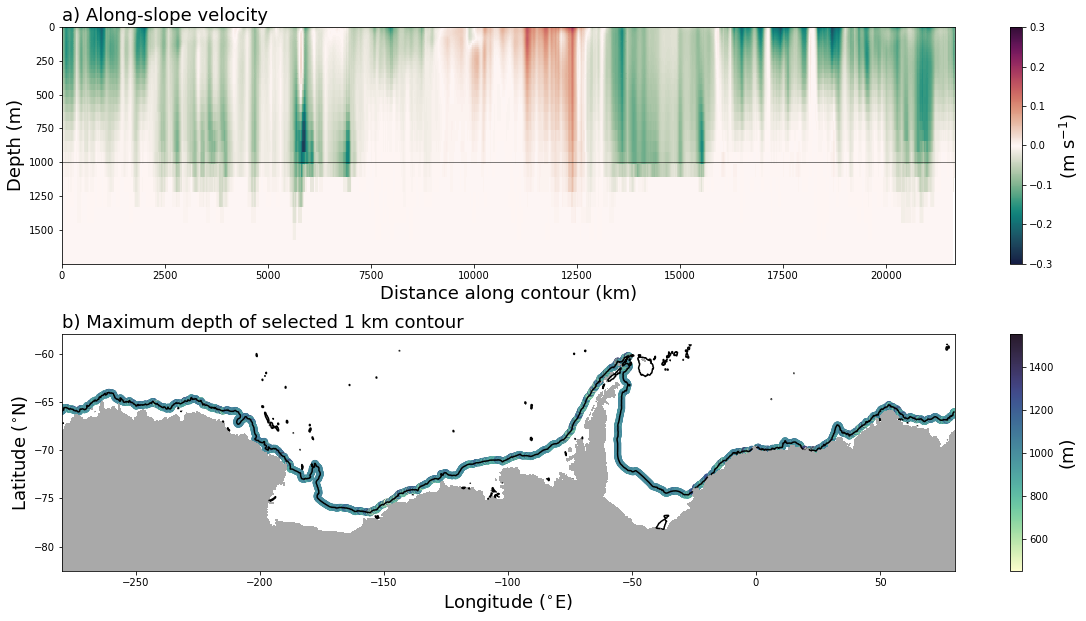

In [124]:
# 1. Plot along-velocity along 1000-m isobath + smoothing in along-slope direction: *plt_approach*
fig = plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('a) Along-slope velocity', fontsize=ft_size, loc='left')
sc = plt.pcolormesh(distance_along_contour, st_ocean, u_along_clim.mean(axis=0),vmin=-0.3, vmax=0.3, cmap=cm.cm.curl)
cbar = plt.colorbar(sc)
cbar.set_label('(m s$^{-1}$)', fontsize=ft_size)
plt.axhline(1000, color='k', linewidth=0.5)
plt.ylim(1750, 0)
plt.yticks(np.arange(0, 1750, 250))
plt.xlabel('Distance along contour (km)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

plt.subplot(2,1,2)
plt.title('b) Maximum depth of selected 1 km contour', fontsize=ft_size, loc='left')
sc = plt.scatter(lon_along_contour, lat_along_contour, c=max_depth, vmin=450, vmax=1550, cmap=cm.cm.deep)
cbar = plt.colorbar(sc)
cbar.set_label('(m)', fontsize=ft_size)
#plt.scatter(lon_along_contour, lat_along_contour, c=u_btr_contour[0,:], vmin=-0.2, vmax=0.2, cmap=cm.cm.curl)
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[1000], colors='k')
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)

plt.subplots_adjust(hspace=0.3);

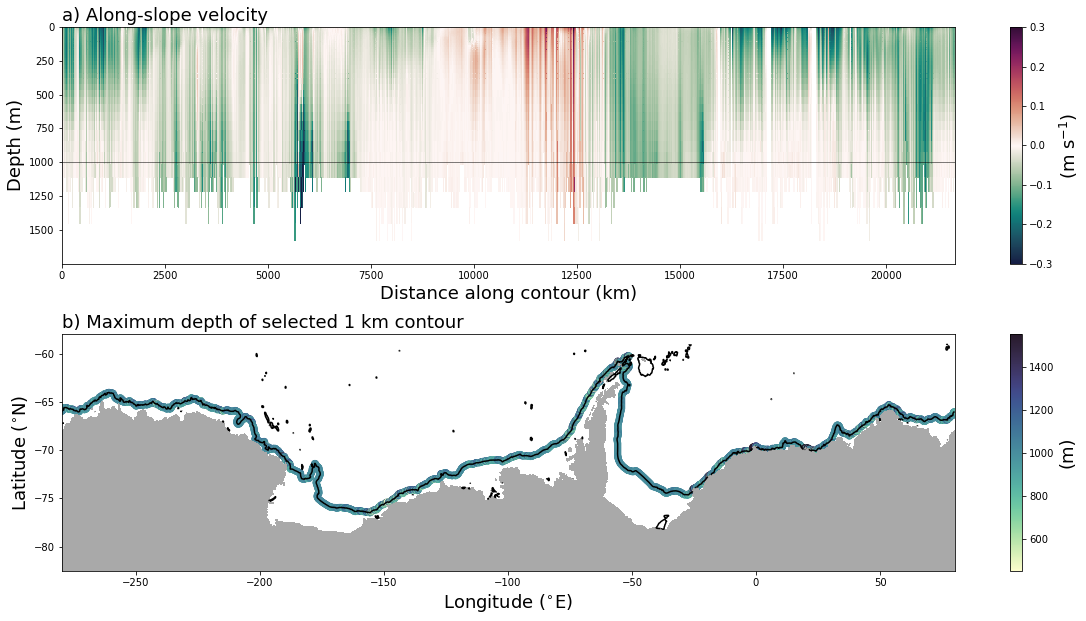

In [22]:
# 2. Plot along-velocity along 1000-m isobath + no smoothing: *plt_approach*
fig = plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('a) Along-slope velocity', fontsize=ft_size, loc='left')
sc = plt.pcolormesh(distance_along_contour, st_ocean, u_along_contour.mean(axis=0),vmin=-0.3, vmax=0.3, cmap=cm.cm.curl)
cbar = plt.colorbar(sc)
cbar.set_label('(m s$^{-1}$)', fontsize=ft_size)
plt.axhline(1000, color='k', linewidth=0.5)
plt.ylim(1750, 0)
plt.yticks(np.arange(0, 1750, 250))
plt.xlabel('Distance along contour (km)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

plt.subplot(2,1,2)
plt.title('b) Maximum depth of selected 1 km contour', fontsize=ft_size, loc='left')
sc = plt.scatter(lon_along_contour, lat_along_contour, c=max_depth, vmin=450, vmax=1550, cmap=cm.cm.deep)
cbar = plt.colorbar(sc)
cbar.set_label('(m)', fontsize=ft_size)
#plt.scatter(lon_along_contour, lat_along_contour, c=u_btr_contour[0,:], vmin=-0.2, vmax=0.2, cmap=cm.cm.curl)
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[1000], colors='k')
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)

plt.subplots_adjust(hspace=0.3);

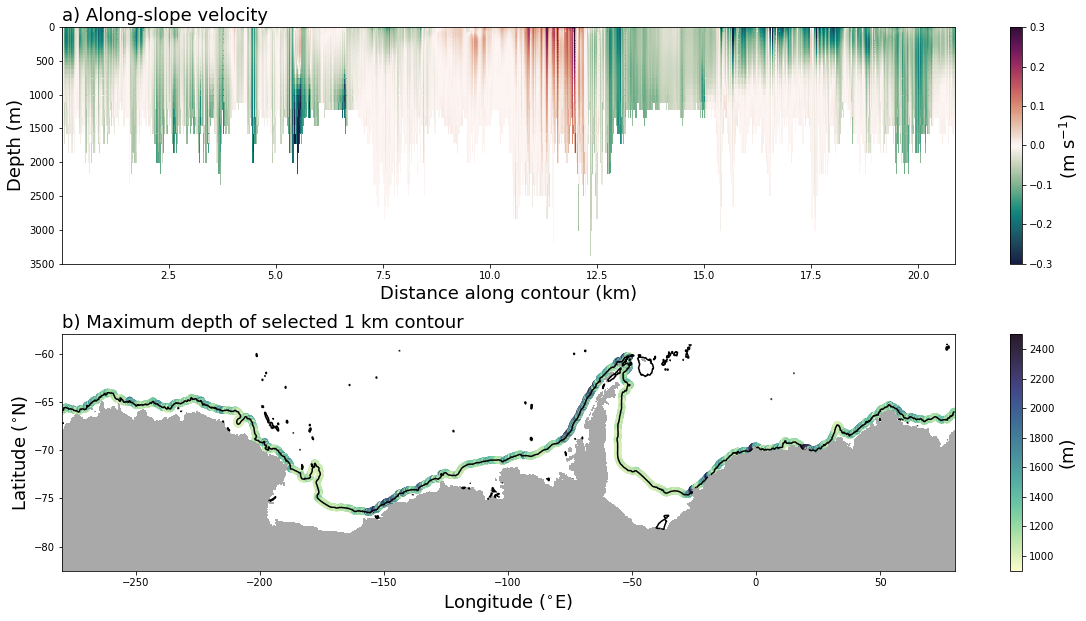

In [60]:
# 3. Plot along-velocity along 1000-m isobath + no smoothing: *mask_approach*
fig = plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.title('a) Along-slope velocity', fontsize=ft_size, loc='left')
sc = plt.pcolormesh(distance_along_contour, st_ocean, u_along_contour.mean(axis=0),vmin=-0.3, vmax=0.3, cmap=cm.cm.curl)
cbar = plt.colorbar(sc)
cbar.set_label('(m s$^{-1}$)', fontsize=ft_size)
plt.ylim(3500, 0)
plt.xlabel('Distance along contour (km)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

plt.subplot(2,1,2)
plt.title('b) Maximum depth of selected 1 km contour', fontsize=ft_size, loc='left')
sc = plt.scatter(lon_along_contour, lat_along_contour, c=max_depth, vmin=900, vmax=2500, cmap=cm.cm.deep)
cbar = plt.colorbar(sc)
cbar.set_label('(m)', fontsize=ft_size)
#plt.scatter(lon_along_contour, lat_along_contour, c=u_btr_contour[0,:], vmin=-0.2, vmax=0.2, cmap=cm.cm.curl)
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[1000], colors='k')
plt.xlim(lon_along_contour.min(), lon_along_contour.max())
plt.ylim(-82.5, -58)
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
plt.ylabel('Latitude ($^{\circ}$N)', fontsize=ft_size)

plt.subplots_adjust(hspace=0.3);

### ASC regimes

Define regime based on the along-slope velocity:  
- 2 - reverse flow: barotropic velocity is positive, otherwise it's one of the below cases
- 1 - bottom-intensified flow (0.5*bottom flow >= surface flow)
- 0 - surface-intensified flow (rest)

Play around with the definition: 
- The code below tests a few different definitions for the bottom-intensified flow. I find that it changes a little bit, but because I smooth the data with the final regime definition anyway, it doesn't matter much which threshold is used for distinguishing the surface-intensified from the bottom-intensified regime.
- I can also test the impact of the definition of the "surface layer" and the "bottom layer". In the end, I use the following values: The surface flow is a vertical average over the upper 200 m, and the bottom flow is a vertical average over the bottom 300 m.

In [16]:
# Array that has the depth levels
depth_array = np.zeros((np.size(u_along_contour,1), np.size(u_along_contour,2)))
for ii in range(np.size(u_along_contour,2)):
    depth_array[:,ii] = u_along_contour[0,:,ii] * 0 + st_ocean
# Get max depth of data (skipping nans)
max_depth = np.nanmax(depth_array, axis=0) 

In [17]:
# Make a 2d array
st_ocean_2d = np.tile(st_ocean, (np.size(thickness_contour, 1),1)).transpose()

Function to calculate the ASC regimes

In [18]:
def calculate_regimes(data_full, data_btr, upper_depth, lower_depth, depth_flag=0, n_val=1):
    """
    depth_flag: average over constant depth to seafloor (depth_flag=0); 
                or over the bottom lower_depth m (depth_flag=1); 
                or from some depth to 1000 m (depth_flag=2)
    n_val: ease restriction that bottom flow has to be larger than surface flow
    upper_depth: water column depth to average to (from surface) for surface flow
    lower_depth: water column depth to average from (to bottom) for for depth_flag=0; or depth of water column above seafloor to average over
    """
    
    # Surface-intensified ASC: zeros
    ASC_regimes_tmp = np.zeros(num_points)

    # Bottom-intensified ASC: ones
    if depth_flag == 0:
        thickness_lower = np.where(st_ocean_2d >= lower_depth, thickness_contour, np.nan)
        u_along_lower   = np.where(st_ocean_2d >= lower_depth, data_full, np.nan)
    elif depth_flag == 1:
        thickness_lower = np.where(st_ocean_2d >= max_depth-lower_depth, thickness_contour, np.nan)  
        u_along_lower   = np.where(st_ocean_2d >= max_depth-lower_depth, data_full, np.nan)
    elif depth_flag == 2:
        thickness_lower = np.where(st_ocean_2d <= 1000, thickness_contour, np.nan)
        u_along_lower   = np.where(st_ocean_2d <= 1000, data_full, np.nan)
        thickness_lower = np.where(st_ocean_2d >= lower_depth, thickness_lower, np.nan)
        u_along_lower   = np.where(st_ocean_2d >= lower_depth, u_along_lower, np.nan)
    thickness_upper = np.where(st_ocean_2d <= upper_depth, thickness_contour, np.nan)
    u_along_upper   = np.where(st_ocean_2d <= upper_depth, data_full, np.nan)
    # Vertical averaging
    u_along_lower = np.nansum(u_along_lower * thickness_lower, axis=0) / np.nansum(thickness_lower, axis=0)
    u_along_upper = np.nansum(u_along_upper * thickness_upper, axis=0) / np.nansum(thickness_upper, axis=0)
    # Check if surface flow < bottom flow
    ASC_regimes_tmp[np.abs(u_along_upper)*n_val <= np.abs(u_along_lower)] = 1

    # Reverse ASC: twos
    ASC_regimes_tmp[data_btr > 0] = 2
    
    # Finished
    return ASC_regimes_tmp

Test a few different vertical averages

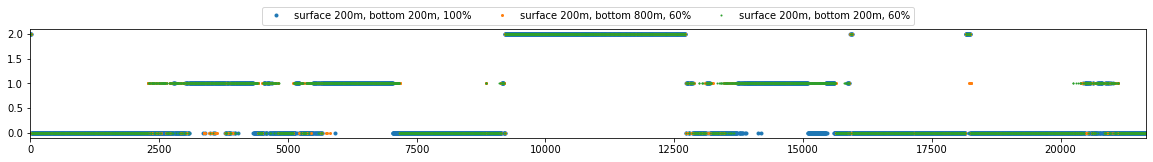

In [65]:
# Using my script for contour selection (making use of plt.contour function)
fig = plt.figure(figsize=(20,2))      

plt.subplot(1,1,1)
ASC_regimes_tmp = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 700, 0, 1)
ASC_regimes_tmp = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 700, 0, 0.6)
ASC_regimes_tmp = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 200, 1, 1)
plt.plot(distance_along_contour, ASC_regimes_tmp, 'o', label='surface 200m, bottom 200m, 100%', markersize=3)
ASC_regimes_tmp = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 800, 2, 0.6)
plt.plot(distance_along_contour, ASC_regimes_tmp, 'o', label='surface 200m, bottom 800m, 60%', markersize=2)
ASC_regimes_tmp = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 200, 1, 0.6)
plt.plot(distance_along_contour, ASC_regimes_tmp, 'o', label='surface 200m, bottom 200m, 60%', markersize=1)
plt.xlim(distance_along_contour.min(), distance_along_contour.max())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5);

Notes:
- The larger the water column depth we average over (same for surface and bottom), the more likely it is to get bottom-intensified flow: the surface flow usually reduces within a few hundred meters vs the bottom flow spreads higher up in the water column.
- In the end, we want a rather smooth field (next step), so individual outliers are not of interest. 
- Overall, the definitions are not too sensitive on the way I define the bottom-intensified flow.
- Go with the "surface 200m, bottom 200m" one for the rest of the script.
- Relaxing the condition that the bottom flow only has to be e.g. 80% of the surface flow leads to more of the bottom-intensified regime.

The above plots are from the unsmoothed product, I didn't rerun the script for the smoothed data (which is the one that I use for the final product).

As a final step, the regime classification is smoothed in along-slope direction. Below a figure to show the effect (on a random classification, I think I used the bottom flow is 60% of surface flow, but that doesn't really matter - it's more about showing how the smoothing is done).

In [19]:
# Smoothed along-slope velocity
ASC_regimes_tmp    = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 200, 1, 1)
ASC_regimes_tmp_60 = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 200, 1, 0.6)

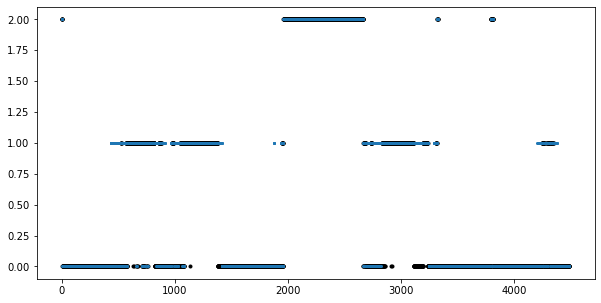

In [94]:
fig = plt.figure(figsize=(10,5))

plt.plot(ASC_regimes_tmp, 'o', color='k', markersize=3)
plt.plot(ASC_regimes_tmp_60, 'o', color='C0', markersize=2)


Snapshot

(70.0, 0.0)

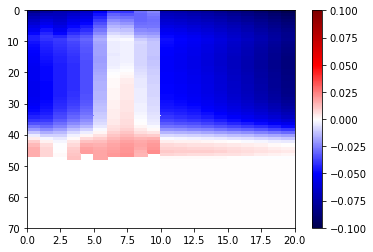

In [27]:
fig = plt.figure()

plt.pcolormesh(u_along_clim[0,:,:20], cmap='seismic', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.ylim(70,0)

Smooth the regime array in along-slope direction:  
In a window of length N, check which regime is predominant and select that for the window's mid point.

In [20]:
from collections import Counter
import more_itertools

# Subdivide the array with the regime information from above in chunks of N values
N = 31
windowed_ASC_regimes = list(more_itertools.windowed(ASC_regimes_tmp_60, n=N))

# Create a new (final) array for the regime information and give it the predominant value from that window
ASC_regimes = np.zeros(num_points)
for ii in range(np.size(windowed_ASC_regimes, 0)-1):
    tmp = Counter(windowed_ASC_regimes[ii]).most_common(1)[0][0]
    ASC_regimes[ii+int(N/2)] = tmp
    
# Make the field 2d for plotting with pcolormesh
#ASC_regimes_2d = np.vstack((ASC_regimes, ASC_regimes))

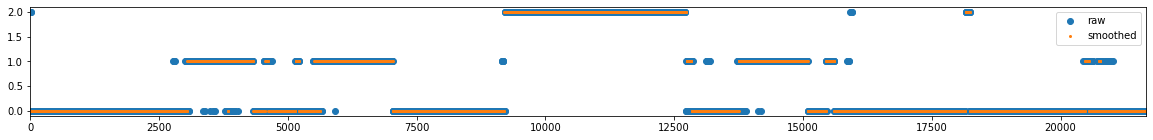

In [46]:
# bottom flow > surface flow
fig = plt.figure(figsize=(20,2))      

plt.subplot(1,1,1)
plt.plot(distance_along_contour, ASC_regimes_tmp, 'o', label='raw')
plt.plot(distance_along_contour, ASC_regimes, 'o', label='smoothed', markersize=2)
plt.xlim(distance_along_contour.min(), distance_along_contour.max())
#plt.xlim(2.5, 5)
plt.legend();

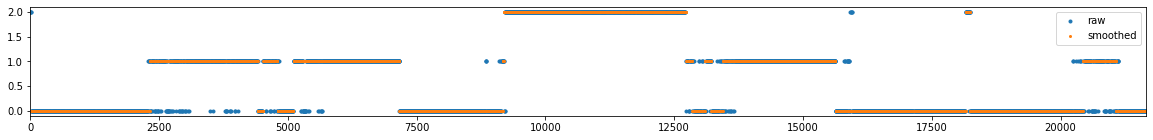

In [60]:
# bottom flow * 0.6 > surface flow
fig = plt.figure(figsize=(20,2))      

plt.subplot(1,1,1)
plt.plot(distance_along_contour, ASC_regimes_tmp_60, 'o', label='raw', markersize=3)
plt.plot(distance_along_contour, ASC_regimes, 'o', label='smoothed', markersize=2)
plt.xlim(distance_along_contour.min(), distance_along_contour.max())
#plt.xlim(2.5, 5)
plt.legend();

### Putting it all together

In [32]:
import os
file_path = '/g/data/x77/wgh581/Post_Process/'

Annual aveage (10 yr data), along-slope velocity is smoothed, regime classification is smoothed (N=31), bottom: lower 200 m, 50% of surface velocity

In [38]:
# Monthly
ASC_regimes_monthly = np.zeros((12, 4487))
for tt in range(12):
    ASC_regimes_tmp = calculate_regimes(u_along_clim[tt,:,:], u_btr_clim[tt,:], 200, 200, 1, 0.5)
    # Along-slope smoothing
    windowed_ASC_regimes_tmp = list(more_itertools.windowed(ASC_regimes_tmp, n=N))
    # Create a new (final) array for the regime information and give it the predominant value from that window
    ASC_regimes = np.zeros(num_points)
    for ii in range(np.size(windowed_ASC_regimes_tmp, 0)-1):
        tmp = Counter(windowed_ASC_regimes_tmp[ii]).most_common(1)[0][0]
        ASC_regimes[ii+int(N/2)] = tmp
    ASC_regimes_monthly[tt,:] = ASC_regimes

# Annual
ASC_regimes_tmp = calculate_regimes(u_along_clim.mean(axis=0), u_btr_clim.mean(axis=0), 200, 200, 1, 0.5)
# Along-slope smoothing
windowed_ASC_regimes_tmp = list(more_itertools.windowed(ASC_regimes_tmp, n=N))
# Create a new (final) array for the regime information and give it the predominant value from that window
ASC_regimes = np.zeros(num_points)
for ii in range(np.size(windowed_ASC_regimes_tmp, 0)-1):
    tmp = Counter(windowed_ASC_regimes_tmp[ii]).most_common(1)[0][0]
    ASC_regimes[ii+int(N/2)] = tmp

# Finished
save_flag = 1
if save_flag == 1:
    outfile = os.path.join(file_path, 'ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz')
    np.savez(outfile, ASC_regimes_annual=ASC_regimes, ASC_regimes_monthly=ASC_regimes_monthly)